In [1]:
import cv2
import matplotlib.pyplot as plt

def show_2images(in_pathfile, out_pathfile):
  # Đường dẫn tới hai bức ảnh
  image_path1 = in_pathfile
  image_path2 = out_pathfile

  # Đọc hai bức ảnh
  image1 = cv2.imread(image_path1)  # Đọc bức ảnh thứ nhất
  image2 = cv2.imread(image_path2)  # Đọc bức ảnh thứ hai

  # Chuyển đổi màu sắc từ BGR sang RGB (để matplotlib hiển thị đúng)
  image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

  # Hiển thị hai bức ảnh cạnh nhau
  plt.figure(figsize=(15, 10))  # Kích thước của hình hiển thị (chiều rộng, chiều cao)

  # Hiển thị bức ảnh thứ nhất bên trái
  plt.subplot(1, 2, 1)
  plt.imshow(image1_rgb)
  # plt.title('INPUT IMAGE')
  plt.title('INPUT IMAGE\n{} x {}'.format(image1_rgb.shape[1], image1_rgb.shape[0]))
  plt.axis('off')  # Tắt trục toạ độ

  # Hiển thị bức ảnh thứ hai bên phải
  plt.subplot(1, 2, 2)
  plt.imshow(image2_rgb)
  # plt.title('OUPUT IMAGE')
  plt.title('OUTPUT IMAGE\n{} x {}'.format(image2_rgb.shape[1], image2_rgb.shape[0]))

  plt.axis('off')  # Tắt trục toạ độ

  plt.show()  # Hiển thị hai bức ảnh cạnh nhau

In [2]:
from PIL import Image
import numpy as np
import cv2
from numba import jit, njit, cuda
import argparse
import time

In [3]:
def get_image(pathfile):
  img = cv2.imread(pathfile)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  return img

def show_image(img):
  return Image.fromarray(img)

def save_image(img, pathfile):
  cv2.imwrite(pathfile, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def rotate90_right(img):
  img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  return img

def rotate90_left(img):
  img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  return img


In [4]:
@njit
def convert_RGB2Gray(img):
    height, width = img.shape[:2]
    gray_img = np.empty((height, width))
    for i in range(height):
        for j in range(width):
            gray_img[i][j] = img[i][j][0]*0.299 + img[i][j][1]*0.587 + img[i][j][2]*0.114

    return gray_img

In [5]:
@njit
def detect_edges(img):
  x_sobel_filter = np.array([
      [1.0, 2.0, 1.0],
      [0.0, 0.0, 0.0],
      [-1.0, -2.0, -1.0]
  ])

  y_sobel_filter = np.array([
      [1.0, 0.0, -1.0],
      [2.0, 0.0, -2.0],
      [1.0, 0.0, -1.0]
  ])

  img_padded = np.zeros((img.shape[0]+2, img.shape[1]+2))
  img_padded[1:-1,1:-1] = img

  energy_map = np.zeros_like(img)

  for x in range(img.shape[1]):
      for y in range(img.shape[0]):
          # element-wise multiplication of the kernel and the image
          gx = (x_sobel_filter * img_padded[y: y+3, x: x+3]).sum()
          gy = (y_sobel_filter * img_padded[y: y+3, x: x+3]).sum()
          energy_map[y, x] = np.absolute(gx) + np.absolute(gy)

  return energy_map

In [6]:
@njit
def forward_energy(gray_img):
    height, width = gray_img.shape[:2]

    energy = np.zeros((height, width))
    m = np.zeros((height, width))

    for r in range(1, height):
        for c in range(width):
            up = (r-1) % height
            left = (c-1) % width
            right = (c+1) % width

            mU = m[up, c]
            mL = m[up, left]
            mR = m[up, right]

            cU = np.abs(gray_img[r, right] - gray_img[r, left])
            cL = np.abs(gray_img[up, c] - gray_img[r, left]) + cU
            cR = np.abs(gray_img[up, c] - gray_img[r, right]) + cU

            cULR = np.array([cU, cL, cR])
            mULR = np.array([mU, mL, mR]) + cULR

            argmin = np.argmin(mULR)

            m[r, c] = mULR[argmin]
            energy[r, c] = cULR[argmin]

    return energy


In [7]:
@njit
def get_least_importance_pixels(energy_map):

  outPixels = np.zeros((energy_map.shape[0], energy_map.shape[1]))

  height, width = energy_map.shape[:2]

  # # giữ nguyên hàng cuối cùng
  outPixels[height-1][:width] = energy_map[height-1][:width]

  for r in range(height-2, -1, -1):
    for c in range(width):
      if c==0:
        outPixels[r][c] = min(outPixels[r+1,:2]) + energy_map[r][c]
        continue
      if c == width - 1:
        outPixels[r][c] = min(outPixels[r+1,width-2:]) +energy_map[r][c]
        continue

      outPixels[r][c] = min(outPixels[r+1,c-1:c+2]) + energy_map[r][c]

  return outPixels

In [8]:
@njit
def find_seam(inPixels):
  min_index = np.argmin(inPixels[0])
  height, width = inPixels.shape[:2]
  idxSeam = []
  idxSeam.append(min_index)

  for r in range(1, height):
    if min_index == 0:
      min_index = np.argmin(inPixels[r][min_index:min_index+2])
      idxSeam.append(min_index)
      continue

    if min_index == width - 1:
      min_index = np.argmin(inPixels[r][min_index-1:min_index+1]) + min_index - 1
      idxSeam.append(min_index)
      continue

    min_index = np.argmin(inPixels[r][min_index-1:min_index+2]) + min_index - 1
    idxSeam.append(min_index)

  return idxSeam

In [9]:
@njit
def remove_seam(img, idxSeam):
  height, width = img.shape[:2]

  outPixels = np.zeros((height, width-1, 3), dtype=np.uint8)

  for r in range(height):
    outPixels[r][:idxSeam[r]][:] = img[r][:idxSeam[r]][:]
    outPixels[r][idxSeam[r]:][:] = img[r][idxSeam[r]+1:][:]

  return outPixels

In [10]:
@njit
def remove_nSeams(img, nSeams):
  for _ in range(nSeams):
    grayImg = convert_RGB2Gray(img)

    importanceMatrix = forward_energy(grayImg)

    leastImportanceMatrix = get_least_importance_pixels(importanceMatrix)

    pathSeam = find_seam(leastImportanceMatrix)

    img = remove_seam(img, pathSeam)

  return img

In [11]:
def create_position_matrix(height, width):
    return np.tile(np.arange(width, dtype=np.int16), (height, 1))

@njit
def update_position_matrix(in_matrix, pathSeam):
    height, width = in_matrix.shape

    out_matrix = np.zeros((height, width-1), dtype=np.int16)

    for r in range(height):

      out_matrix[r][:pathSeam[r]] = in_matrix[r][:pathSeam[r]]
      out_matrix[r][pathSeam[r]:] = in_matrix[r][pathSeam[r]+1:]

    return out_matrix

In [12]:
def insert_seams(img, position_matrix, nSeams):
  height, width = img.shape[:2]

  out_img = np.zeros((height, width + nSeams, 3), dtype=np.uint8)

  for r in range(height):

    position = position_matrix[r]

    for i in range(width-nSeams):
      out_img[r][position[i]*2-i] = img[r][position[i]]

    position_dup = np.setdiff1d(np.arange(width), position)

    for i in range(nSeams):
      out_img[r][position_dup[i]+i] = img[r][position_dup[i]]
      out_img[r][position_dup[i]+i+1] = img[r][position_dup[i]]

  return out_img

In [13]:
def insert_nSeams(img, nSeams):
  height, width = img.shape[:2]
  ratio_resize = nSeams / width
  ratio_default = 0.5
  if ratio_resize <= ratio_default:
    tmp_img = img.copy()
    position_matrix = create_position_matrix(height, width)

    for _ in range(nSeams):
      gray_img = convert_RGB2Gray(tmp_img)

      energy_map = forward_energy(gray_img)

      leastImportacePixels = get_least_importance_pixels(energy_map)

      pathSeam = find_seam(leastImportacePixels)

      position_matrix = update_position_matrix(position_matrix, pathSeam)

      tmp_img = remove_seam(tmp_img, pathSeam)

    img = insert_seams(img, position_matrix, nSeams)

    return img

  else:
    kSeams = int(width * ratio_default)
    img = insert_nSeams(img, kSeams)
    img = insert_nSeams(img, nSeams - kSeams)
  return img

# CHAY CHUONG TRINH

In [14]:
import cv2
import matplotlib.pyplot as plt

def show_2images(in_pathfile, out_pathfile):
  # Đường dẫn tới hai bức ảnh
  image_path1 = in_pathfile
  image_path2 = out_pathfile

  # Đọc hai bức ảnh
  image1 = cv2.imread(image_path1)  # Đọc bức ảnh thứ nhất
  image2 = cv2.imread(image_path2)  # Đọc bức ảnh thứ hai

  # Chuyển đổi màu sắc từ BGR sang RGB (để matplotlib hiển thị đúng)
  image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

  # Hiển thị hai bức ảnh cạnh nhau
  plt.figure(figsize=(15, 10))  # Kích thước của hình hiển thị (chiều rộng, chiều cao)

  # Hiển thị bức ảnh thứ nhất bên trái
  plt.subplot(1, 2, 1)
  plt.imshow(image1_rgb)
  # plt.title('INPUT IMAGE')
  plt.title('INPUT IMAGE\n{} x {}'.format(image1_rgb.shape[1], image1_rgb.shape[0]))
  plt.axis('off')  # Tắt trục toạ độ

  # Hiển thị bức ảnh thứ hai bên phải
  plt.subplot(1, 2, 2)
  plt.imshow(image2_rgb)
  # plt.title('OUPUT IMAGE')
  plt.title('OUTPUT IMAGE\n{} x {}'.format(image2_rgb.shape[1], image2_rgb.shape[0]))

  plt.axis('off')  # Tắt trục toạ độ

  plt.show()  # Hiển thị hai bức ảnh cạnh nhau

In [15]:
%%writefile resize_image_sequential.py

from PIL import Image
import numpy as np
import cv2
from numba import jit, njit, cuda
import argparse
import time

#///////////////////////////////////////////////////
def get_image(pathfile):
  img = cv2.imread(pathfile)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  return img

def show_image(img):
  return Image.fromarray(img)

def save_image(img, pathfile):
  cv2.imwrite(pathfile, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def rotate90_right(img):
  img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  return img

def rotate90_left(img):
  img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  return img

#///////////////////////////////////////////////////
def convert_RGB2Gray(img):
    height, width = img.shape[:2]
    gray_img = np.empty((height, width))
    for i in range(height):
        for j in range(width):
            gray_img[i][j] = img[i][j][0]*0.299 + img[i][j][1]*0.587 + img[i][j][2]*0.114

    return gray_img


#////////////////////////////////////////////////////
def detect_edges(img):
  x_sobel_filter = np.array([
      [1.0, 2.0, 1.0],
      [0.0, 0.0, 0.0],
      [-1.0, -2.0, -1.0]
  ])

  y_sobel_filter = np.array([
      [1.0, 0.0, -1.0],
      [2.0, 0.0, -2.0],
      [1.0, 0.0, -1.0]
  ])

  img_padded = np.zeros((img.shape[0]+2, img.shape[1]+2))
  img_padded[1:-1,1:-1] = img

  energy_map = np.zeros_like(img)

  for x in range(img.shape[1]):
      for y in range(img.shape[0]):
          # element-wise multiplication of the kernel and the image
          gx = (x_sobel_filter * img_padded[y: y+3, x: x+3]).sum()
          gy = (y_sobel_filter * img_padded[y: y+3, x: x+3]).sum()
          energy_map[y, x] = np.absolute(gx) + np.absolute(gy)

  return energy_map
#////////////////////////////////////////////////////
def forward_energy(gray_img):
    height, width = gray_img.shape[:2]

    energy = np.zeros((height, width))
    m = np.zeros((height, width))

    for r in range(1, height):
        for c in range(width):
            up = (r-1) % height
            left = (c-1) % width
            right = (c+1) % width

            mU = m[up, c]
            mL = m[up, left]
            mR = m[up, right]

            cU = np.abs(gray_img[r, right] - gray_img[r, left])
            cL = np.abs(gray_img[up, c] - gray_img[r, left]) + cU
            cR = np.abs(gray_img[up, c] - gray_img[r, right]) + cU

            cULR = np.array([cU, cL, cR])
            mULR = np.array([mU, mL, mR]) + cULR

            argmin = np.argmin(mULR)

            m[r, c] = mULR[argmin]
            energy[r, c] = cULR[argmin]

    return energy
#////////////////////////////////////////////////////
def get_least_importance_pixels(energy_map):

  outPixels = np.zeros((energy_map.shape[0], energy_map.shape[1]))

  height, width = energy_map.shape[:2]

  # # giữ nguyên hàng cuối cùng
  outPixels[height-1][:width] = energy_map[height-1][:width]

  for r in range(height-2, -1, -1):
    for c in range(width):
      if c==0:
        outPixels[r][c] = min(outPixels[r+1,:2]) + energy_map[r][c]
        continue
      if c == width - 1:
        outPixels[r][c] = min(outPixels[r+1,width-2:]) +energy_map[r][c]
        continue

      outPixels[r][c] = min(outPixels[r+1,c-1:c+2]) + energy_map[r][c]

  return outPixels
#////////////////////////////////////////////////////
def find_seam(inPixels):
  min_index = np.argmin(inPixels[0])
  height, width = inPixels.shape[:2]
  idxSeam = []
  idxSeam.append(min_index)

  for r in range(1, height):
    if min_index == 0:
      min_index = np.argmin(inPixels[r][min_index:min_index+2])
      idxSeam.append(min_index)
      continue

    if min_index == width - 1:
      min_index = np.argmin(inPixels[r][min_index-1:min_index+1]) + min_index - 1
      idxSeam.append(min_index)
      continue

    min_index = np.argmin(inPixels[r][min_index-1:min_index+2]) + min_index - 1
    idxSeam.append(min_index)

  return idxSeam
#////////////////////////////////////////////////////
def remove_seam(img, idxSeam):
  height, width = img.shape[:2]

  outPixels = np.zeros((height, width-1, 3), dtype=np.uint8)

  for r in range(height):
    outPixels[r][:idxSeam[r]][:] = img[r][:idxSeam[r]][:]
    outPixels[r][idxSeam[r]:][:] = img[r][idxSeam[r]+1:][:]

  return outPixels
#////////////////////////////////////////////////////
def remove_nSeams(img, nSeams):
  for _ in range(nSeams):
    grayImg = convert_RGB2Gray(img)

    importanceMatrix = forward_energy(grayImg)

    leastImportanceMatrix = get_least_importance_pixels(importanceMatrix)

    pathSeam = find_seam(leastImportanceMatrix)

    img = remove_seam(img, pathSeam)

  return img
#////////////////////////////////////////////////////
def create_position_matrix(height, width):
    return np.tile(np.arange(width, dtype=np.int16), (height, 1))

def update_position_matrix(in_matrix, pathSeam):
    height, width = in_matrix.shape

    out_matrix = np.zeros((height, width-1), dtype=np.int16)

    for r in range(height):

      out_matrix[r][:pathSeam[r]] = in_matrix[r][:pathSeam[r]]
      out_matrix[r][pathSeam[r]:] = in_matrix[r][pathSeam[r]+1:]

    return out_matrix
#////////////////////////////////////////////////////
def insert_seams(img, position_matrix, nSeams):
  height, width = img.shape[:2]

  out_img = np.zeros((height, width + nSeams, 3), dtype=np.uint8)

  for r in range(height):

    position = position_matrix[r]

    for i in range(width-nSeams):
      out_img[r][position[i]*2-i] = img[r][position[i]]

    position_dup = np.setdiff1d(np.arange(width), position)

    for i in range(nSeams):
      out_img[r][position_dup[i]+i] = img[r][position_dup[i]]
      out_img[r][position_dup[i]+i+1] = img[r][position_dup[i]]

  return out_img
#////////////////////////////////////////////////////
def insert_nSeams(img, nSeams, ratio_default):
  height, width = img.shape[:2]
  ratio_resize = nSeams / width
  if ratio_resize <= ratio_default:
    tmp_img = img.copy()
    position_matrix = create_position_matrix(height, width)

    for _ in range(nSeams):
      gray_img = convert_RGB2Gray(tmp_img)

      energy_map = forward_energy(gray_img)

      leastImportacePixels = get_least_importance_pixels(energy_map)

      pathSeam = find_seam(leastImportacePixels)

      position_matrix = update_position_matrix(position_matrix, pathSeam)

      tmp_img = remove_seam(tmp_img, pathSeam)

    img = insert_seams(img, position_matrix, nSeams)

    return img

  else:
    kSeams = int(width * ratio_default)
    img = insert_nSeams(img, kSeams, ratio_default)
    img = insert_nSeams(img, nSeams - kSeams, ratio_default)
  return img
#////////////////////////////////////////////////////
if __name__ == '__main__':
  print("Resize image Sequential \n")
  # Tạo đối tượng ArgumentParser
  parser = argparse.ArgumentParser()

  # Thêm các đối số và tùy chọn
  parser.add_argument("-input", type=str, help='path file input')
  parser.add_argument('-output', type=str, help='path file output')

  parser.add_argument('-dx', type=int, help='number of seams - axis x', default = 0)
  parser.add_argument('-dy', type=int, help='number of seams - axis y', default = 0)

  parser.add_argument('-ratio_resize', type=float, help='ratio resize image (0->1) ', default = 0.5)

  # Phân tích các tham số dòng lệnh
  args = parser.parse_args()

  img = get_image(args.input)
  print("INPUT:", img.shape)

  start = time.perf_counter()
  if args.dx < 0:
    img = remove_nSeams(img, abs(args.dx))

  if args.dy < 0:
    img = rotate90_left(img)
    img = remove_nSeams(img, abs(args.dy))
    img = rotate90_right(img)

  if args.dx > 0:
      img = insert_nSeams(img, args.dx, args.ratio_resize)

  if args.dy > 0:
    img = rotate90_left(img)
    img = insert_nSeams(img, args.dy, args.ratio_resize)
    img = rotate90_right(img)

  end = time.perf_counter()
  print("OUTPUT:", img.shape)
  print("RUNTIME:",round(end - start,3), "seconds")

  save_image(img, args.output)

Writing resize_image_sequential.py


In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/insert_300rows.jpg" -dx 300

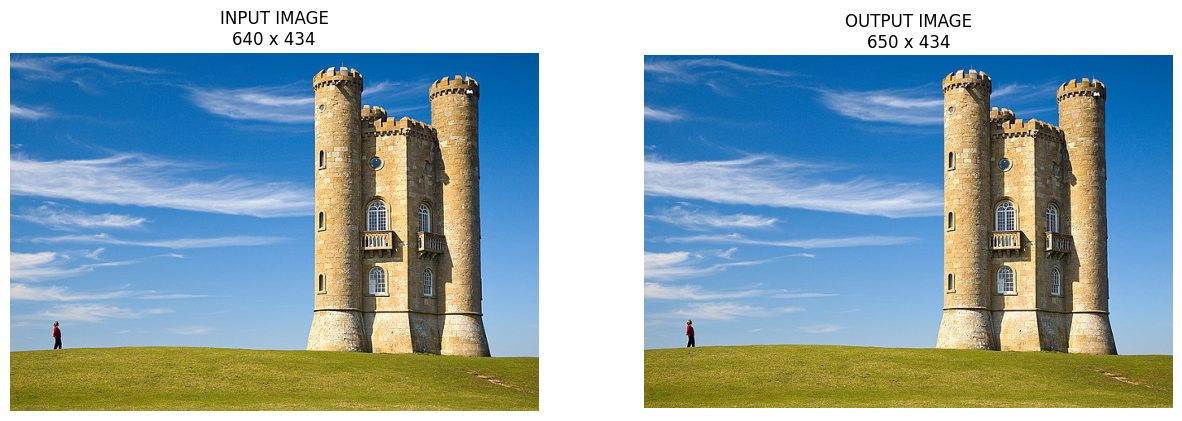

In [17]:
show_2images("/content/original.jpg","/content/insert_300rows.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/insert_300cols.jpg" -dy 300

In [ ]:
show_2images("/content/original.jpg","/content/insert_300cols.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/remove_300rows.jpg" -dx -300

In [ ]:
show_2images("/content/original.jpg","/content/remove_300rows.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/remove_300cols.jpg" -dy -300

In [ ]:
show_2images("/content/original.jpg","/content/remove_300cols.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/insert_200rows_insert_200cols.jpg" -dx 200 -dy 200

In [ ]:
show_2images("/content/original.jpg","/content/insert_200rows_insert_200cols.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/remove_200rows_remove_200cols.jpg" -dx -200 -dy -200

In [ ]:
show_2images("/content/original.jpg","/content/remove_200rows_remove_200cols.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/insert_200rows_remove_200cols.jpg" -dx 200 -dy -200

In [ ]:
show_2images("/content/original.jpg","/content/insert_200rows_remove_200cols.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/original_2x.jpg" -dx 640 -dy 434

In [ ]:
show_2images("/content/original.jpg","/content/original_2x.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/original_2x_with_ratio_1.jpg" -ratio_resize 1 -dx 640 -dy 434

In [ ]:
show_2images("/content/original.jpg","/content/original_2x_with_ratio_1.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/original_3x.jpg" -dx 1280 -dy 868

In [ ]:
show_2images("/content/original.jpg","/content/original_3x.jpg")

In [ ]:
!python resize_image_sequential.py -input "/content/original.jpg" -output "/content/original_3x_with_ratio_1.jpg" -ratio_resize 1 -dx 1280 -dy 868

In [ ]:
show_2images("/content/original.jpg","/content/original_3x_with_ratio_1.jpg")